In [1]:
%%time
import json
import inspect
import tqdm
import contractions
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 

import Artha
from Artha.nlp_extraction import *


from Artha.binance_api.client import Client
import Artha.configs.binance_config as c 
import time
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

CPU times: user 2.39 s, sys: 398 ms, total: 2.79 s
Wall time: 3.36 s


In [2]:
%%time
# loading tweets from user
# user = "BTC_JackSparrow"
user = "CryptoKaleo"
with open("../data/tweets/u"+user+"tweets.json", "r") as r:
    tweets = json.load(r)
tweet_text = []
for ind, tweet in enumerate(tweets):
    sent = tweet["full_text"]
    
    try: #remove tweets of only tagging someone
        while sent[0] == "@":
            sent = sent.split(" ", 1)[1]
        sent = contractions.fix(sent.replace("&amp;", "and").replace("@", ""))
        tweet_text.append((sent, {"created_at":tweet["created_at"], "id" :tweet["id"]}))
    except: #pops tweet if a tweet only consists of tags
        tweets.pop(ind)

CPU times: user 143 ms, sys: 12.9 ms, total: 156 ms
Wall time: 156 ms


In [3]:
%%time
# process all docs
docs = []
for doc, context in nlp.pipe(tweet_text, as_tuples = True, n_process=-1): # need to disable pipes to run faster

    doc._.tweet_id = context["id"]
    doc._.tweeted_at = datetime.strftime(datetime.strptime(context["created_at"],'%a %b %d %H:%M:%S +0000 %Y'), '%m/%d/%Y %H:%M:%S')
    docs.append(doc)

CPU times: user 2.31 s, sys: 178 ms, total: 2.49 s
Wall time: 4.21 s


In [4]:
%%time
# keep info from docs that only have BTC
cur_tick = "BTC"
tweet_scores = [[doc._.tweeted_at, doc._.polarity, ind] for ind, doc in enumerate(docs) if cur_tick in doc._.tickers]
len(tweet_scores)

CPU times: user 43.9 ms, sys: 1.47 ms, total: 45.3 ms
Wall time: 44.5 ms


323

In [6]:
# removes tweets that were posted close to each other, and averages polarity
i = 0
while i < len(tweet_scores)-1:
    cur_tweet = tweet_scores[i]
    next_tweet = tweet_scores[i+1]

    cur_time = datetime.strptime(cur_tweet[0], '%m/%d/%Y %H:%M:%S')
    next_time = datetime.strptime(next_tweet[0], '%m/%d/%Y %H:%M:%S')

    time_diff = cur_time-next_time

    if time_diff < timedelta(seconds = 5):
        tweet_scores[i][1] = (cur_tweet[1]+next_tweet[1])/2
        popped = tweet_scores.pop(i+1)
    else:
        i+=1
print("done", len(tweet_scores))

done 322


In [7]:
%%time
tweet_times = pd.to_datetime([i[0] for i in tweet_scores])
final_tweet_scores = [i[1] for i in tweet_scores]
tweet_scores_df = pd.Series(final_tweet_scores, index = tweet_times)

In [8]:
%%time
key = c.apis[0][0]
secret = c.apis[0][1]
client = Client(key, secret)

def get_klines(asset, interval, start, end = None):
    if end:
        return client.get_historical_klines(asset, interval, start, end)
    else:
        return client.get_historical_klines(asset, interval, start)

def get_date_str(date):
    obj = datetime.fromtimestamp(date/1000.0)
    return "%s/%s/%s %s:%s:%s" % (obj.month, obj.day, obj.year, obj.hour, obj.minute, obj.second)

asset = "BTCUSDT"
klines = get_klines(asset, Client.KLINE_INTERVAL_30MINUTE, "19 March, 2021", "24 April 2021")

CPU times: user 109 ms, sys: 42.6 ms, total: 151 ms
Wall time: 4.22 s


In [9]:
%%time
def get_dataframe(klines, periods = len(klines)):
    columns = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "Quote Asset Volume", "Number of Trades", "Taker Buy Base Volume", "Taker Buy Quote Asset Volume", "Ignore"]
    print(periods)
    return pd.DataFrame.from_records(
                klines,
                index = pd.date_range(start = get_date_str(klines[0][0]),
                                      end = get_date_str(klines[-1][0]),
                                      periods = periods),
                columns = columns)

df = get_dataframe(klines)
df2 = df["Close"].reindex(pd.date_range(start=df.index.min(),
                                        end=df.index.max(),
                                        freq='T')).astype(float).interpolate(method='linear')

1816
CPU times: user 23.7 ms, sys: 5.78 ms, total: 29.5 ms
Wall time: 27.8 ms


Text(0.5, 1.0, 'BTCUSDT')

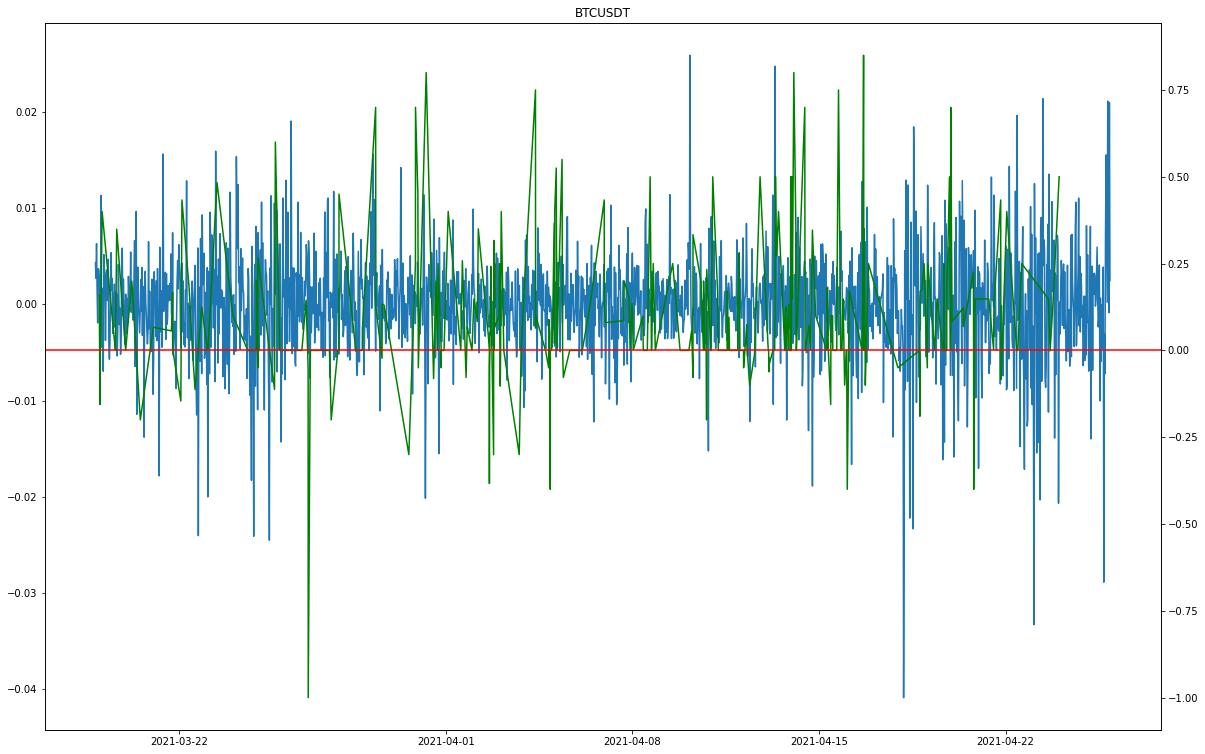

In [10]:
plt.rcParams['figure.figsize'] = [20, 13]
ts = df["Close"].astype(float).pct_change()

fig, ax1 = plt.subplots()
ax1.plot(ts)
ax2 = ax1.twinx()
ax2.plot(tweet_scores_df, color='g')
plt.axhline(y=0, color='r', linestyle='-')
plt.title(asset)